# Loan Club: Machine Learning Capstone Notebook

In [1]:
# Load packages
import pandas as pd
import numpy as np
import re
from time import strptime  # format data columns
import warnings
import math

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")  # ignore warnings throughout notebook
pd.set_option("display.max_columns", None)  # show all columns

In [2]:
# Load Data
filepath = "../data/accepted_subsampled_5percent.csv" #will be personalized
df = pd.read_csv(filepath, sep=",")

df_cleaned = df.copy() #work from second copy

In [3]:
# Features known to investors based on LC website
known_vars = ['acc_now_delinq',             # accounts now deliquent
              'collections_12_mths_ex_med', # collections excluding medical
              'fico_range_high',            # credit score range
              'fico_range_low',             # creit score range
              'delinq_2yrs',                # delinquencies in last two years
              'delinq_amnt',                # delinquency amount
              'earliest_cr_line',           # earliest credit line
              'home_ownership',             # home ownership
              'dti',                        # debt2income ratio
              'annual_inc',                 # annual income
              'initial_list_status',        # initial listing status
              'inq_last_6mths',             # credit inquires in last 6mo
              'int_rate',                   # interest rate
              'verification_status_joint',  # is this a joint app
              'emp_length',                 # length of employment (yr)
              'loan_amnt',                  # loan amount
              'id',                         # loan id
              'purpose',                    # purpose of the loan
              'term',                       # loan term (3 or 5yr)
              'addr_state',                 # borrower location state
              'installment',                # montly payment
              'mths_since_last_delinq',     # mo since last delinquency
              'mths_since_last_major_derog',# mo since last maj. derogatory
              'mths_since_last_record',     # mo since last public record
              'open_acc',                   # open credit line
              'pub_rec',                    # public records on file
              'revol_util',                 # revolving balance utilization (%)
              'revol_bal',                  # revolving credit balance ($)
              'tot_coll_amt',               # total collection amount ever
              'total_acc',                  # total credit lines
              'tot_cur_bal',                # total current balance
              'verification_status',        # verified income (Y/N I think)
              'grade'                       # loan grade
             ]

# Sanity check, print variable if not found within original dataframe
# [ print(var) for var in known_vars if (var not in df.columns)]


### Impute Missing Data of Known Variables

In [4]:
#Assess missingness of known variables
missingness = df_cleaned[known_vars].isnull().mean().T
missingness = missingness.loc[missingness>0].sort_values(ascending=False)
missingness


verification_status_joint      0.949313
mths_since_last_record         0.838543
mths_since_last_major_derog    0.744395
mths_since_last_delinq         0.513786
emp_length                     0.063868
tot_cur_bal                    0.033430
tot_coll_amt                   0.033430
revol_util                     0.001006
dti                            0.000829
collections_12_mths_ex_med     0.000476
open_acc                       0.000185
pub_rec                        0.000185
total_acc                      0.000185
inq_last_6mths                 0.000185
earliest_cr_line               0.000185
delinq_amnt                    0.000185
delinq_2yrs                    0.000185
acc_now_delinq                 0.000185
dtype: float64

In [5]:
# Drop features missing > 50% 
feat_wManyMissing = missingness.index[np.where(missingness > .5)].to_list()
df_cleaned[known_vars].drop(df_cleaned[feat_wManyMissing], axis=1, inplace=True)
[known_vars.remove(var) for var in feat_wManyMissing] #remove features from known_var list


[None, None, None, None]

In [6]:
# Replace NA's of numeric 'known_var' features with mean value
numeric_var = ['tot_cur_bal',
               'tot_coll_amt',
               'revol_util',
               'collections_12_mths_ex_med',
               'open_acc',
               'pub_rec',
               'total_acc',
               'inq_last_6mths',
               'delinq_amnt',
               'delinq_2yrs',
               'dti' ]

# List comprehension through numerica variables
[df_cleaned[var].fillna(df[var].mean(), inplace=True) for var in numeric_var]


[None, None, None, None, None, None, None, None, None, None, None]

In [7]:
# Helper function to replace missing character strings with randomly selected value
def fillna_random(var):
    #find index of missing values
    miss_idx = df_cleaned.loc[ df_cleaned[var].isnull()].index.tolist()
    
    #find new values to replace NaN values
    new_val = df_cleaned[var].loc[~df_cleaned.index.isin(miss_idx)].sample(len(miss_idx)).values.tolist()

    #replace values
    df_cleaned[var][miss_idx] = new_val

# ==================================================
# Replace NA's of character 'known_var' features with random
non_numeric_var = ['emp_length', 'earliest_cr_line', 'acc_now_delinq', 'delinq_2yrs'] #list of non-numeric variables
[fillna_random(var) for var in non_numeric_var]


[None, None, None, None]

In [8]:
#Sanity check that no more missing values
df_cleaned[known_vars].isnull().sum()


acc_now_delinq                0
collections_12_mths_ex_med    0
fico_range_high               0
fico_range_low                0
delinq_2yrs                   0
delinq_amnt                   0
earliest_cr_line              0
home_ownership                0
dti                           0
annual_inc                    0
initial_list_status           0
inq_last_6mths                0
int_rate                      0
emp_length                    0
loan_amnt                     0
id                            0
purpose                       0
term                          0
addr_state                    0
installment                   0
open_acc                      0
pub_rec                       0
revol_util                    0
revol_bal                     0
tot_coll_amt                  0
total_acc                     0
tot_cur_bal                   0
verification_status           0
grade                         0
dtype: int64

### Feature Engineering

In [9]:
# Simplify loan status (non-FullyPaid or ChargedOff loans will be converted to NAN)
df_cleaned['loan_status'] = df_cleaned['loan_status'].map({'Fully Paid':'Fully Paid',
                                                           'Charged Off':'Charged Off',
                                                           'Does not meet the credit policy. Status:Fully Paid': 'Fully Paid',
                                                           'Does not meet the credit policy. Status:Charged Off': 'Charged Off'})

# Remove non-completed loans
df_cleaned.drop(df_cleaned.loc[df_cleaned['loan_status'].isnull()].index.tolist(), axis=0, inplace=True)

# Simplify home ownership
df_cleaned['home_ownership'] = df_cleaned['home_ownership'].map({'MORTGAGE':'mortgage',
                                                                 'OWN':'own',
                                                                 'RENT':'rent'})

# Remove 25 observations without houses
df_cleaned.drop(df_cleaned.loc[df_cleaned['home_ownership'].isnull()].index.tolist(), axis=0, inplace=True)


# Reformat date features and calculate features related to prepayment  
df_cleaned['term_year'] = np.where(df_cleaned['term']==' 36 months', 3,5)
df_cleaned['earliest_cr_line'] =  pd.to_datetime(df_cleaned['earliest_cr_line'])
df_cleaned['issue_date'] =  pd.to_datetime(df_cleaned['issue_d'])
df_cleaned['last_pymnt_date'] = pd.to_datetime(df_cleaned['last_pymnt_d'])
df_cleaned['exp_last_pymnt_date'] = pd.to_datetime(df_cleaned['issue_d'].str[0:3]
                                                   +'-'
                                                   + (df_cleaned['issue_d'].str[-4:].astype('int')
                                                   + df_cleaned['term_year']).astype('str'))

# Calculate credit history ( in months )
date_ofloan = df_cleaned['issue_date'].dt.to_period('M').astype(int)
date_credline = df_cleaned['earliest_cr_line'].dt.to_period('M').astype(int)
df_cleaned['credit_hist_mths'] = date_ofloan - date_credline
df_cleaned['credit_hist_mths'] = np.where(df_cleaned['credit_hist_mths'] < 0, 0, df_cleaned['credit_hist_mths'])

# Log-transform skewed continuous features
df_cleaned['delinq_amnt_log'] = df_cleaned['delinq_amnt'].add(1).apply(np.log)
df_cleaned['annual_inc_log'] = df_cleaned['annual_inc'].add(1).apply(np.log)
df_cleaned['dti_log'] = df_cleaned['dti'].add(1).apply(np.log)
df_cleaned['funded_amnt_log'] = df_cleaned['funded_amnt'].add(1).apply(np.log)
df_cleaned['tot_coll_amt_log'] = df_cleaned['tot_coll_amt'].add(1).apply(np.log)
df_cleaned['tot_cur_bal_log'] = df_cleaned['tot_cur_bal'].add(1).apply(np.log)
df_cleaned['total_acc_log'] = df_cleaned['total_acc'].add(1).apply(np.log)
df_cleaned['revol_bal_log'] = df_cleaned['revol_bal'].add(1).apply(np.log)
df_cleaned['installment_log'] = df_cleaned['installment'].add(1).apply(np.log)
df_cleaned['open_acc_log'] = df_cleaned['open_acc'].add(1).apply(np.log)

# Simplify loan purpose - debt consolidation, credit card, and other
df_cleaned['purpose'] = df_cleaned['purpose'].map({'debt_consolidation':'debt_consolidation',
                                                   'credit_card':'credit_card'})
df_cleaned['purpose'].fillna('other',inplace=True)

# Convert loan grade to ordinal feature
df_cleaned['grade'] = df_cleaned['grade'].map({'A':1,
                                               'B':2,
                                               'C':3,
                                               'D':4,
                                               'E':5,
                                               'F':6,
                                               'G':7})

# Simplify employment length to four categories
df_cleaned['emp_length'] = df_cleaned['emp_length'].map({'< 1 year':0.5,
                                                         '1 year':1,
                                                         '2 years':2,
                                                         '3 years':3,
                                                         '4 years':4,
                                                         '5 years':5,
                                                         '6 years':6,
                                                         '7 years':7,
                                                         '8 years':8,
                                                         '9 years':9,
                                                         '10+ years':10})

# Create new binary features
df_cleaned['has_pub_rec'] = np.where(df_cleaned['pub_rec']>0,1,0) #0-=no public record
df_cleaned['has_paid_early'] = np.where((df_cleaned.loan_status=='Fully Paid')&(df_cleaned.last_pymnt_date < df_cleaned.exp_last_pymnt_date), 1, 0)
df_cleaned['has_36mo_loan'] = np.where(df_cleaned['term'].str.contains('36'),1,0) #0=60mo loan
df_cleaned['has_delinq_now'] = np.where(df_cleaned['acc_now_delinq']>0, 1, 0)
df_cleaned['has_delinq_past2yrs'] = np.where(df_cleaned['delinq_2yrs']>0, 1, 0) #0=no delinq within 2yrs
df_cleaned['has_whole_liststatus'] = np.where(df_cleaned['initial_list_status']=='w', 1, 0) #0=f
df_cleaned['has_fullypaid'] = np.where(df_cleaned['loan_status']=='Fully Paid', 1, 0) #0=charged off


In [10]:
# Create response variable based on 
threshold = -20 #goal % return
df_cleaned["roi_perc"] = df_cleaned["total_pymnt"].div(df_cleaned["funded_amnt"]).sub(1).mul(100)
df_cleaned['roi_response'] = np.where(df_cleaned['roi_perc'] > threshold, 1, 0)

print('Fraction of loans above threadhold: %.3f' % df_cleaned['roi_response'].mean())

# ==================================================================
# Majority class [1] = ROI >-20% (IDEAL)
# Minority class [0] = ROI <-20% (BAD)

Fraction of loans above threadhold: 0.838


In [11]:
# Isolate list of predictor variables to be used for ML
predictor_vars = ['annual_inc_log',
                  'credit_hist_mths',
                  'delinq_amnt_log',
                  'dti_log',
                  'emp_length',
                  'fico_range_high',
                  'funded_amnt_log',
                  'grade',
                  'has_36mo_loan',
                  'has_delinq_now',
                  'has_delinq_past2yrs',
                  'has_pub_rec',
                  'has_whole_liststatus',
                  'home_ownership',
                  'inq_last_6mths',
                  'installment_log',
                  'int_rate',
                  'open_acc_log',
                  'purpose',
                  'revol_bal_log',
                  'revol_util',
                  'tot_coll_amt_log',
                  'tot_cur_bal_log',
                  'total_acc_log',
                  'verification_status']

response_var = 'roi_response'


# Machine Learning

### Logistic Regression
- Goal is to build classifier that predicts if loan results in desirable outcome
- Should also report feature importance

In [12]:
# Dummify categorical features
home_ownership_dummy = pd.get_dummies(df_cleaned['home_ownership'],
                                      prefix="home_ownership").drop('home_ownership_mortgage',axis=1)

purpose_dummy = pd.get_dummies(df_cleaned['purpose'],
                               prefix="purpose").drop('purpose_debt_consolidation',axis=1)

verification_status_dummy = pd.get_dummies(df_cleaned['verification_status'],
                               prefix="verification_status").drop('verification_status_Source Verified',axis=1)


In [13]:
# List of numeric features in the final dataframe
numeric_vars = ['annual_inc_log',
                'credit_hist_mths',
                'delinq_amnt_log',
                'dti_log',
                'emp_length',
                'fico_range_high',
                'funded_amnt_log',
                'grade',
                'has_36mo_loan',
                'has_delinq_now',
                'has_delinq_past2yrs',
                'has_pub_rec',
                'has_whole_liststatus',
                'inq_last_6mths',
                'installment_log',
                'int_rate',
                'open_acc_log',
                'revol_bal_log',
                'revol_util',
                'tot_coll_amt_log',
                'tot_cur_bal_log',
                'total_acc_log']


In [14]:
# final dataframe for model consumption
df_feature_final = pd.concat([df_cleaned[numeric_vars],
                      home_ownership_dummy,
                      purpose_dummy,
                      verification_status_dummy],axis=1)

### Tree-Based Model
- Goal is to build classifier that predicts if loan results in desirable outcome
- Should also report feature importance

- Initially explored Random Forest algorithm but switched to XGboost due to time constraint


In [48]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, auc, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, recall_score, roc_auc_score

#### Naive XGBoost Model - Imbalanced Data (83.8% ROI>-20%)

*Goal is to minimize false positives* - Maximixe precision
- Majority class [1] = ROI >-20% (IDEAL)
- Minority class [0] = ROI <-20% (BAD)



Training ROC-AUC score is: 0.514
Test ROC-AUC score is: 0.508
Test Area Under P-R Curve: 0.920

Confusion Matrix:
 [[   46  2141]
 [   51 11323]]

2141 of 2187 [97.9%]loans ROI<-20% were incorrectly labeled as ROI>-20%


Text(0.5, 1.0, 'Binary Precision-Recall curve: AP=0.84')

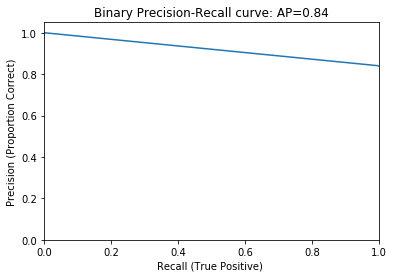

In [16]:
#Create test-train split of data
x = df_feature_final
y = df_cleaned[response_var] #labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

#Create random forest object
naive_model = xgb.XGBClassifier(objective = 'binary:logistic')

#Fit model with data
naive_model.fit(x_train, y_train)

# ==================== Print Results ====================
model = naive_model
train_score = roc_auc_score(y_train, model.predict(x_train))
print('\nTraining ROC-AUC score is: %.3f' % train_score)
test_score = roc_auc_score(y_test, model.predict(x_test))
print('Test ROC-AUC score is: %.3f' % test_score)
precision, recall, _ = precision_recall_curve(y_test, model.predict(x_test))
print('Test Area Under P-R Curve: %.3f\n' % auc(recall, precision))
cm = confusion_matrix(y_test, model.predict(x_test))
print('Confusion Matrix:\n', cm)
print('\n{0} of {1} [{2}%]loans ROI<-20% were incorrectly labeled as ROI>-20%'.format(cm[0,1], 
                                                                                    cm[0,0]+cm[0,1], 
                                                                                    round(100*cm[0,1]/(cm[0,0]+cm[0,1]),2)))

# ==================== P-R Curve Plot ====================
average_precision = average_precision_score(y_test, model.predict(x_test))
plt.plot(recall, precision)
plt.xlabel('Recall (True Positive) ')
plt.ylabel('Precision (Proportion Correct)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

#### Naive XGBoost Model - using scale_pos_weight parameter


Training ROC-AUC score is: 0.670
Test ROC-AUC score is: 0.653
Test Area Under P-R Curve: 0.925

Confusion Matrix:
 [[1467  720]
 [4153 7221]]

720 of 2187 [32.92%]loans ROI<-20% were incorrectly labeled as ROI>-20%


Text(0.5, 1.0, 'Binary Precision-Recall curve: AP=0.88')

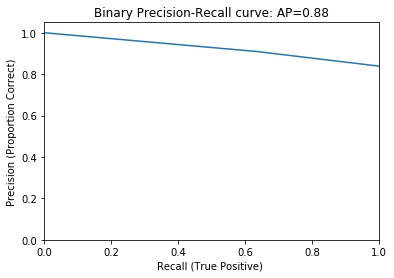

In [17]:
#Create random forest object
#scale_pos_weight = sum(negative) / sum(positive)
naive_model = xgb.XGBClassifier(objective = 'binary:logistic', 
                                scale_pos_weight=(len(y)-y.sum())/y.sum(), #84% of ROI >-20% [1]
                                eval_matrix = 'aucpr') #PR AUC - goal to minimze False positives 

#Fit model with data
naive_model.fit(x_train, y_train)

# ==================== Print Results ====================
model = naive_model
train_score = roc_auc_score(y_train, model.predict(x_train))
print('\nTraining ROC-AUC score is: %.3f' % train_score)
test_score = roc_auc_score(y_test, model.predict(x_test))
print('Test ROC-AUC score is: %.3f' % test_score)
precision, recall, _ = precision_recall_curve(y_test, model.predict(x_test))
print('Test Area Under P-R Curve: %.3f\n' % auc(recall, precision))
cm = confusion_matrix(y_test, model.predict(x_test))
print('Confusion Matrix:\n', cm)
print('\n{0} of {1} [{2}%]loans ROI<-20% were incorrectly labeled as ROI>-20%'.format(cm[0,1], 
                                                                                    cm[0,0]+cm[0,1],                                            round(100*cm[0,1]/(cm[0,0]+cm[0,1]),2)))

# ==================== P-R Curve Plot ====================
y_pred = model.predict(x_test)
average_precision = average_precision_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.xlabel('Recall (True Positive) ')
plt.ylabel('Precision (Proportion Correct)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

    weight    auc_PR  accuracy    recall  precision  false_discovery_rate  \
16    0.17  0.884048  0.600619  0.575611   0.917461              0.082539   
17    0.18  0.882902  0.618243  0.603042   0.911980              0.088020   
18    0.19  0.882646  0.636015  0.629418   0.908503              0.091497   
14    0.15  0.882585  0.557112  0.514243   0.924013              0.075987   
15    0.16  0.882253  0.576432  0.542905   0.918899              0.081101   

    false_pos_rate  error_rate  n_true_pos  n_false_pos  
16        0.269319    0.399381      6547.0        589.0  
17        0.302698    0.381757      6859.0        662.0  
18        0.329675    0.363985      7159.0        721.0  
14        0.219936    0.442888      5849.0        481.0  
15        0.249200    0.423568      6175.0        545.0  
CPU times: user 2min 57s, sys: 1.67 s, total: 2min 59s
Wall time: 3min 1s


Text(0.5, 1.0, 'Binary Precision-Recall curve: AP=0.84')

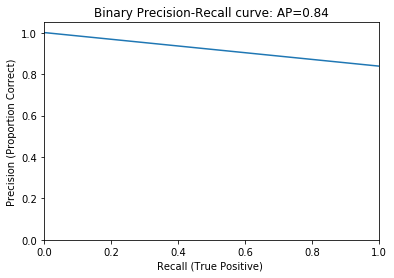

In [98]:
%%time
#TUNE SCALE_POS_WEIGHT VALUE

x = df_feature_final
y = df_cleaned[response_var] #labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

store = pd.DataFrame([], columns=['weight',
                                  'auc_PR',
                                  'accuracy',
                                  'recall',
                                  'precision',
                                  'false_discovery_rate',
                                  'false_pos_rate',
                                  'error_rate',
                                  'n_true_pos',
                                  'n_false_pos'])

weights = [i/100 for i in range(1,20)]
for weight in weights:
    #Create random forest object
    #scale_pos_weight = sum(negative) / sum(positive)
    naive_model = xgb.XGBClassifier(objective = 'binary:logistic', 
                                    scale_pos_weight = weight,
                                    eval_matrix = 'aucpr',
                                    seed = 0) #PR AUC - goal to minimze False positives 

    #Fit model with data
    naive_model.fit(x_train, y_train)
    
    #Analyze
    tn, fp, fn, tp = confusion_matrix(y_test, naive_model.predict(x_test)).ravel()
    
    store = store.append({'weight':weight,
                          'auc_PR': average_precision_score(y_test, naive_model.predict(x_test)),
                          'accuracy': (tp + tn) / (tp + tn + fn + fp),
                          'recall': tp / (tp + fn),
                          'precision': tp/(tp+fp),
                          'false_discovery_rate': fp/(fp+tp),
                          'false_pos_rate': fp / (tn + fp),
                          'error_rate': (fp + fn) / (tp + tn + fn + fp),
                          'n_true_pos':tp, 
                          'n_false_pos':fp}, ignore_index = True)

store = store.sort_values(by='auc_PR',ascending=False)
print(store.head())
                     
# ==================== P-R Curve Plot ====================
model = xgb.XGBClassifier(objective = 'binary:logistic',
                          scale_pos_weight=store.weight[0],
                          eval_matrix = 'aucpr')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
auc_PR = average_precision_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.xlabel('Recall (True Positive) ')
plt.ylabel('Precision (Proportion Correct)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Precision-Recall curve: '
                   'auc_PR={0:0.2f}'.format(auc_PR))


In [102]:
len(list(range(100,1500,50)))

28

   n_estimators    auc_PR  accuracy    recall  precision  \
1         500.0  0.885053  0.623774  0.607966   0.914925   
2        1000.0  0.884560  0.638375  0.630033   0.911473   
0         100.0  0.884048  0.600619  0.575611   0.917461   
3        1500.0  0.882872  0.648920  0.647969   0.906854   

   false_discovery_rate  false_pos_rate  error_rate  n_true_pos  n_false_pos  
1              0.085075        0.294010    0.376226      6915.0        643.0  
2              0.088527        0.318244    0.361625      7166.0        696.0  
0              0.082539        0.269319    0.399381      6547.0        589.0  
3              0.093146        0.346136    0.351080      7370.0        757.0  
CPU times: user 4min 35s, sys: 1.74 s, total: 4min 37s
Wall time: 4min 39s


Text(0.5, 1.0, 'Binary Precision-Recall curve: auc_PR=0.88')

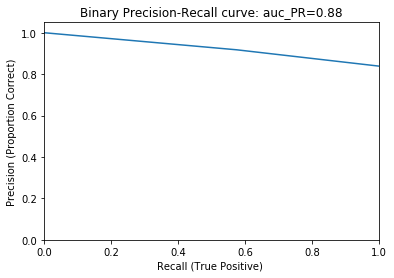

In [99]:
%%time
#TUNE n_estimators
x = df_feature_final
y = df_cleaned[response_var] #labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

store = pd.DataFrame([], columns=['n_estimators',
                                  'auc_PR',
                                  'accuracy',
                                  'recall',
                                  'precision',
                                  'false_discovery_rate',
                                  'false_pos_rate',
                                  'error_rate',
                                  'n_true_pos',
                                  'n_false_pos'])
n_estim = [100, 500, 1000, 1500]
for n in n_estim:
    #Create random forest object
    #scale_pos_weight = sum(negative) / sum(positive)
    naive_model = xgb.XGBClassifier(objective = 'binary:logistic', 
                                    scale_pos_weight = 0.17, 
                                    n_estimators = n
                                    eval_matrix = 'aucpr',
                                    seed = 0) #PR AUC - goal to minimze False positives 

    #Fit model with data
    naive_model.fit(x_train, y_train)
    
    #Analyze
    tn, fp, fn, tp = confusion_matrix(y_test, naive_model.predict(x_test)).ravel()
    
    store = store.append({'n_estimators':n,
                          'auc_PR': average_precision_score(y_test, naive_model.predict(x_test)),
                          'accuracy': (tp + tn) / (tp + tn + fn + fp),
                          'recall': tp / (tp + fn),
                          'precision': tp/(tp+fp),
                          'false_discovery_rate': fp/(fp+tp),
                          'false_pos_rate': fp / (tn + fp),
                          'error_rate': (fp + fn) / (tp + tn + fn + fp),
                          'n_true_pos':tp, 
                          'n_false_pos':fp}, ignore_index = True)

store = store.sort_values(by='auc_PR',ascending=False)
print(store.head())

# ==================== P-R Curve Plot ====================
model = xgb.XGBClassifier(objective = 'binary:logistic',
                          scale_pos_weight=0.17,
                          eval_matrix = 'aucpr')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
auc_PR = average_precision_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.xlabel('Recall (True Positive) ')
plt.ylabel('Precision (Proportion Correct)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Precision-Recall curve: '
                   'auc_PR={0:0.2f}'.format(auc_PR))

**Tuning Hyperparameters**
- max_depth = depth of trees (3-10)
- min_child_weight = similar to min_child_leaf for RandomForest
- gamma = min. loss reduction required for split
- subsample = frac of observations randomly sampled for tree (0.5-1)
- colsample_bytree = number of features sampled for each tree
- learning rate = typically between 0.01-0.2

{'max_depth': 1, 'min_child_weight': 5}
0.923036486287583

Training ROC-AUC score is: 0.665
Test ROC-AUC score is: 0.651
Test Area Under P-R Curve: 0.925

Confusion Matrix:
 [[1471  716]
 [4211 7163]]

716 of 2187 [32.74%]loans ROI<-20% were incorrectly labeled as ROI>-20%
CPU times: user 1min 30s, sys: 676 ms, total: 1min 30s
Wall time: 26min 53s


Text(0.5, 1.0, 'Binary Precision-Recall curve: AP=0.88')

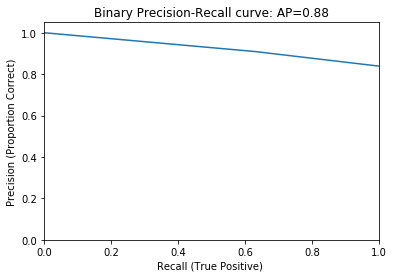

In [18]:
%%time 

#Tune max_depth and min_child_weight
param_test1 = {'max_depth':range(1,5,1),        #typically between 3-10
               'min_child_weight':range(1,6,1)}  #small number selected because of 

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate = 0.1,
                                                      n_estimators = 1000,
                                                      max_depth = 3,
                                                      min_child_weight = 1,
                                                      gamma = 0,
                                                      subsample = 1,
                                                      colsample_bytree = 1,
                                                      objective = 'binary:logistic',
                                                      seed = 0,
                                                      early_stopping_rounds = 5,
                                                      scale_pos_weight=(len(y)-y.sum())/y.sum()), 
                        param_grid = param_test1, 
                        scoring = 'average_precision',
                        n_jobs = -1,
                        iid = False, #returns avg score across folds
                        cv = 5)

gsearch1.fit(x_train,y_train)
print(gsearch1.best_params_) #best parameters from CV
print(gsearch1.best_score_)  #best score from CV

# Enter tuned parameters into new model
xgb1 = xgb.XGBClassifier(learning_rate = 0.1,
                         n_estimators = 1000,
                         max_depth = gsearch1.best_params_['max_depth'],
                         min_child_weight = gsearch1.best_params_['min_child_weight'],
                         gamma = 0,
                         subsample = 1,
                         colsample_bytree = 1,
                         objective = 'binary:logistic',
                         seed = 0,
                         early_stopping_rounds = 5,
                         n_jobs = -1,
                         eval_matrix = 'aucpr',
                         scale_pos_weight=(len(y)-y.sum())/y.sum())

# modelfit(xgb1, train, train_X)
xgb1.fit(x_train, y_train)

# ==================== Print Results ====================
model = xgb1
train_score = roc_auc_score(y_train, model.predict(x_train))
print('\nTraining ROC-AUC score is: %.3f' % train_score)
test_score = roc_auc_score(y_test, model.predict(x_test))
print('Test ROC-AUC score is: %.3f' % test_score)
precision, recall, _ = precision_recall_curve(y_test, model.predict(x_test))
print('Test Area Under P-R Curve: %.3f\n' % auc(recall, precision))
cm = confusion_matrix(y_test, model.predict(x_test))
print('Confusion Matrix:\n', cm)
print('\n{0} of {1} [{2}%]loans ROI<-20% were incorrectly labeled as ROI>-20%\n\n'.format(cm[0,1],
                                                                                          cm[0,0]+cm[0,1],
                                                                                          round(100*cm[0,1]/(cm[0,0]+cm[0,1]),2)))

# ==================== P-R Curve Plot ====================
average_precision = average_precision_score(y_test, model.predict(x_test))
plt.plot(recall, precision)
plt.xlabel('Recall (True Positive) ')
plt.ylabel('Precision (Proportion Correct)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

{'gamma': 0.0}
0.923036486287583

Training ROC-AUC score is: 0.665
Test ROC-AUC score is: 0.651
Test Area Under P-R Curve: 0.925

Confusion Matrix:
 [[1471  716]
 [4211 7163]]

716 of 2187 [32.74%]loans ROI<-20% were incorrectly labeled as ROI>-20%
CPU times: user 1min 30s, sys: 473 ms, total: 1min 30s
Wall time: 5min 55s


Text(0.5, 1.0, 'Binary Precision-Recall curve: AP=0.88')

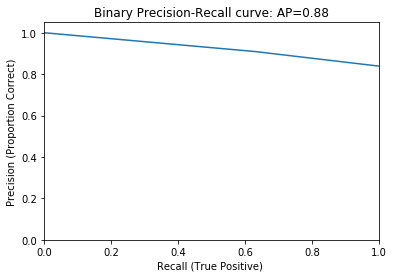

In [19]:
%%time 

#Tune gamma parameter
param_test2 = {'gamma':[i/10 for i in range(0,5)]}  #small number selected because of 

gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate = 0.1,
                                                      n_estimators = 1000,
                                                      max_depth = gsearch1.best_params_['max_depth'],
                                                      min_child_weight = gsearch1.best_params_['min_child_weight'],
                                                      gamma = 0,
                                                      subsample = 1,
                                                      colsample_bytree = 1,
                                                      objective = 'binary:logistic',
                                                      seed = 0,
                                                      early_stopping_rounds = 5, 
                                                      scale_pos_weight=(len(y)-y.sum())/y.sum()), 
                        param_grid = param_test2, 
                        scoring = 'average_precision',
                        n_jobs = -1,
                        iid = False, #returns avg score across folds
                        cv = 5)

gsearch2.fit(x_train,y_train)

print(gsearch2.best_params_)
print(gsearch2.best_score_)

# Enter tuned parameters into new model
xgb2 = xgb.XGBClassifier(learning_rate = 0.1,
                         n_estimators = 1000,
                         max_depth = gsearch1.best_params_['max_depth'],
                         min_child_weight = gsearch1.best_params_['min_child_weight'],
                         gamma = gsearch2.best_params_['gamma'],
                         subsample = 1,
                         colsample_bytree = 1,
                         objective = 'binary:logistic',
                         seed = 0,
                         early_stopping_rounds = 5,
                         n_jobs = -1,
                         eval_matrix = 'aucpr',
                         scale_pos_weight=(len(y)-y.sum())/y.sum()) 

# modelfit(xgb1, train, train_X)
xgb2.fit(x_train, y_train)

# ==================== Print Results ====================
model = xgb2
train_score = roc_auc_score(y_train, model.predict(x_train))
print('\nTraining ROC-AUC score is: %.3f' % train_score)
test_score = roc_auc_score(y_test, model.predict(x_test))
print('Test ROC-AUC score is: %.3f' % test_score)
precision, recall, _ = precision_recall_curve(y_test, model.predict(x_test))
print('Test Area Under P-R Curve: %.3f\n' % auc(recall, precision))
cm = confusion_matrix(y_test, model.predict(x_test))
print('Confusion Matrix:\n', cm)
print('\n{0} of {1} [{2}%]loans ROI<-20% were incorrectly labeled as ROI>-20%\n\n'.format(cm[0,1], 
                                                                                    cm[0,0]+cm[0,1], 
                                                                                    round(100*cm[0,1]/(cm[0,0]+cm[0,1]),2))

# ==================== P-R Curve Plot ====================
average_precision = average_precision_score(y_test, model.predict(x_test))
plt.plot(recall, precision)
plt.xlabel('Recall (True Positive) ')
plt.ylabel('Precision (Proportion Correct)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

{'colsample_bytree': 0.7, 'subsample': 0.6}
0.923101647253287

Training ROC-AUC score is: 0.666
Test ROC-AUC score is: 0.653
Test Area Under P-R Curve: 0.925

Confusion Matrix:
 [[1470  717]
 [4162 7212]]

717 of 2187 [32.78%]loans ROI<-20% were incorrectly labeled as ROI>-20%
CPU times: user 1min 19s, sys: 648 ms, total: 1min 20s
Wall time: 40min 33s


Text(0.5, 1.0, 'Binary Precision-Recall curve: AP=0.88')

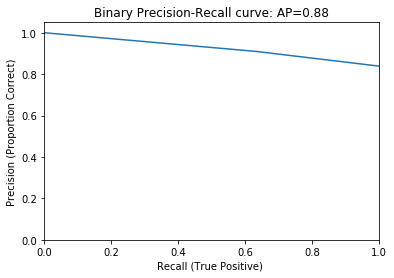

In [20]:
%%time 

#Tune subsample and colsample_bytree parameters
param_test3 = {'subsample':[i/10 for i in range(1,10)],
               'colsample_bytree':[i/10 for i in range(5,15)]}

gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate = 0.1,
                                                      n_estimators = 1000,
                                                      max_depth = gsearch1.best_params_['max_depth'],
                                                      min_child_weight = gsearch1.best_params_['min_child_weight'],
                                                      gamma = gsearch2.best_params_['gamma'],
                                                      subsample = 1,
                                                      colsample_bytree = 1,
                                                      objective = 'binary:logistic',
                                                      seed = 0,
                                                      early_stopping_rounds = 5,
                                                      scale_pos_weight=(len(y)-y.sum())/y.sum()), 
                        param_grid = param_test3, 
                        scoring = 'average_precision',
                        n_jobs = -1,
                        iid = False, #returns avg score across folds
                        cv = 5)

gsearch3.fit(x_train,y_train)

print(gsearch3.best_params_)
print(gsearch3.best_score_)

# Enter tuned parameters into new model
xgb3 = xgb.XGBClassifier(learning_rate = 0.1,
                         n_estimators = 1000,
                         max_depth = gsearch1.best_params_['max_depth'],
                         min_child_weight = gsearch1.best_params_['min_child_weight'],
                         gamma = gsearch2.best_params_['gamma'],
                         subsample = gsearch3.best_params_['subsample'],
                         colsample_bytree = gsearch3.best_params_['colsample_bytree'],
                         objective = 'binary:logistic',
                         seed = 0,
                         early_stopping_rounds = 5,
                         n_jobs = -1,
                         eval_matrix = 'aucpr',
                         scale_pos_weight=(len(y)-y.sum())/y.sum()) 

# modelfit(xgb1, train, train_X)
xgb3.fit(x_train, y_train)

# ==================== Print Results ====================
model = xgb3
train_score = roc_auc_score(y_train, model.predict(x_train))
print('\nTraining ROC-AUC score is: %.3f' % train_score)
test_score = roc_auc_score(y_test, model.predict(x_test))
print('Test ROC-AUC score is: %.3f' % test_score)
precision, recall, _ = precision_recall_curve(y_test, model.predict(x_test))
print('Test Area Under P-R Curve: %.3f\n' % auc(recall, precision))
cm = confusion_matrix(y_test, model.predict(x_test))
print('Confusion Matrix:\n', cm)
print('\n{0} of {1} [{2}%]loans ROI<-20% were incorrectly labeled as ROI>-20%\n\n'.format(cm[0,1], 
                                                                                    cm[0,0]+cm[0,1], 
                                                                                    round(100*cm[0,1]/(cm[0,0]+cm[0,1]),2)))

# ==================== P-R Curve Plot ====================
average_precision = average_precision_score(y_test, model.predict(x_test))
plt.plot(recall, precision)
plt.xlabel('Recall (True Positive) ')
plt.ylabel('Precision (Proportion Correct)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

{'learning_rate': 0.025}
0.922440389448602

Training ROC-AUC score is: 0.659
Test ROC-AUC score is: 0.650
Test Area Under P-R Curve: 0.924

Confusion Matrix:
 [[1487  700]
 [4312 7062]]

700 of 2187 [32.01%]loans ROI<-20% were incorrectly labeled as ROI>-20%
CPU times: user 1min 16s, sys: 161 ms, total: 1min 16s
Wall time: 5min 5s


Text(0.5, 1.0, 'Binary Precision-Recall curve: AP=0.88')

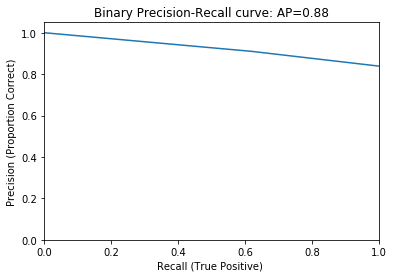

In [21]:
%%time 

#Tune learning rate parameter
param_test4 = {'learning_rate':[i/1000 for i in range(5,30,5)]}

gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate = 0.1,
                                                      n_estimators = 1000,
                                                      max_depth = gsearch1.best_params_['max_depth'],
                                                      min_child_weight = gsearch1.best_params_['min_child_weight'],
                                                      gamma = gsearch2.best_params_['gamma'],
                                                      subsample = gsearch3.best_params_['subsample'],
                                                      colsample_bytree = gsearch3.best_params_['colsample_bytree'],
                                                      objective = 'binary:logistic',
                                                      seed = 0,
                                                      early_stopping_rounds = 5,
                                                      scale_pos_weight=(len(y)-y.sum())/y.sum()), 
                        param_grid = param_test4, 
                        scoring = 'average_precision',
                        n_jobs = -1,
                        iid = False, #returns avg score across folds
                        cv = 5)

gsearch4.fit(x_train,y_train)

print(gsearch4.best_params_)
print(gsearch4.best_score_)

# Enter tuned parameters into new model
xgb4 = xgb.XGBClassifier(learning_rate = gsearch4.best_params_['learning_rate'],
                         n_estimators = 1000,
                         max_depth = gsearch1.best_params_['max_depth'],
                         min_child_weight = gsearch1.best_params_['min_child_weight'],
                         gamma = gsearch2.best_params_['gamma'],
                         subsample = gsearch3.best_params_['subsample'],
                         colsample_bytree = gsearch3.best_params_['colsample_bytree'],
                         objective = 'binary:logistic',
                         seed = 0,
                         early_stopping_rounds = 5,
                         n_jobs = -1,
                         eval_matrix = 'aucpr',
                         scale_pos_weight=(len(y)-y.sum())/y.sum()) 

# modelfit(xgb1, train, train_X)
xgb4.fit(x_train, y_train) #final model

# ==================== Print Results ====================
model = xgb4
train_score = roc_auc_score(y_train, model.predict(x_train))
print('\nTraining ROC-AUC score is: %.3f' % train_score)
test_score = roc_auc_score(y_test, model.predict(x_test))
print('Test ROC-AUC score is: %.3f' % test_score)
precision, recall, _ = precision_recall_curve(y_test, model.predict(x_test))
print('Test Area Under P-R Curve: %.3f\n' % auc(recall, precision))
cm = confusion_matrix(y_test, model.predict(x_test))
print('Confusion Matrix:\n', cm)
print('\n{0} of {1} [{2}%]loans ROI<-20% were incorrectly labeled as ROI>-20%\n\n'.format(cm[0,1], 
                                                                                    cm[0,0]+cm[0,1], 
                                                                                    round(100*cm[0,1]/(cm[0,0]+cm[0,1]),2)))

# ==================== P-R Curve Plot ====================
average_precision = average_precision_score(y_test, model.predict(x_test))
plt.plot(recall, precision)
plt.xlabel('Recall (True Positive) ')
plt.ylabel('Precision (Proportion Correct)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [23]:
# %%time 

# #Tune n_estimators parameter
# param_test5 = {'n_estimators':range(100,1500,50)}

# gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate = gsearch4.best_params_['learning_rate'],
#                                                       n_estimators = 1000,
#                                                       max_depth = gsearch1.best_params_['max_depth'],
#                                                       min_child_weight = gsearch1.best_params_['min_child_weight'],
#                                                       gamma = gsearch2.best_params_['gamma'],
#                                                       subsample = gsearch3.best_params_['subsample'],
#                                                       colsample_bytree = gsearch3.best_params_['colsample_bytree'],
#                                                       objective = 'binary:logistic',
#                                                       seed = 0,
#                                                       early_stopping_rounds = 5,
#                                                       scale_pos_weight=(len(y)-y.sum())/y.sum()), 
#                         param_grid = param_test4, 
#                         scoring = 'average_precision',
#                         n_jobs = -1,
#                         iid = False, #returns avg score across folds
#                         cv = 3)

# gsearch5.fit(x_train,y_train)

# print(gsearch5.best_params_)
# print(gsearch5.best_score_)

# # Enter tuned parameters into new model
# xgb5 = xgb.XGBClassifier(learning_rate = gsearch4.best_params_['learning_rate'],
#                          n_estimators = gsearch5.best_params_['n_estimators'],
#                          max_depth = gsearch1.best_params_['max_depth'],
#                          min_child_weight = gsearch1.best_params_['min_child_weight'],
#                          gamma = gsearch2.best_params_['gamma'],
#                          subsample = gsearch3.best_params_['subsample'],
#                          colsample_bytree = gsearch3.best_params_['colsample_bytree'],
#                          objective = 'binary:logistic',
#                          seed = 0,
#                          early_stopping_rounds = 5,
#                          n_jobs = -1,
#                          eval_matrix = 'aucpr',
#                          scale_pos_weight=(len(y)-y.sum())/y.sum()) 

# # modelfit(xgb1, train, train_X)
# xgb5.fit(x_train, y_train) #final model

# # ==================== Print Results ====================
# model = xgb5
# train_score = roc_auc_score(y_train, model.predict(x_train))
# print('\nTraining ROC-AUC score is: %.3f' % train_score)
# test_score = roc_auc_score(y_test, model.predict(x_test))
# print('Test ROC-AUC score is: %.3f' % test_score)
# precision, recall, _ = precision_recall_curve(y_test, model.predict(x_test))
# print('Test Area Under P-R Curve: %.3f\n' % auc(recall, precision))
# cm = confusion_matrix(y_test, model.predict(x_test))
# print('Confusion Matrix:\n', cm)
# print('\n{0} of {1} [{2}%]loans ROI<-20% were incorrectly labeled as ROI>-20%\n'.format(cm[0,1], 
#                                                                                     cm[0,0]+cm[0,1], 
#                                                                                     round(100*cm[0,1]/(cm[0,0]+cm[0,1]),2)))

# # ==================== P-R Curve Plot ====================
# average_precision = average_precision_score(y_test, model.predict(x_test))
# plt.plot(recall, precision)
# plt.xlabel('Recall (True Positive) ')
# plt.ylabel('Precision (Proportion Correct)')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Binary Precision-Recall curve: '
#                    'AP={0:0.2f}'.format(average_precision))

Test ROC-AUC score is: 0.659
Test Area Under P-R Curve: 0.924

Confusion Matrix:
 [[1487  700]
 [4312 7062]]

700 of 2187 [32.01%]loans ROI<-20% were incorrectly labeled as ROI>-20%




Text(0.5, 1.0, 'Binary Precision-Recall curve: AP=0.88')

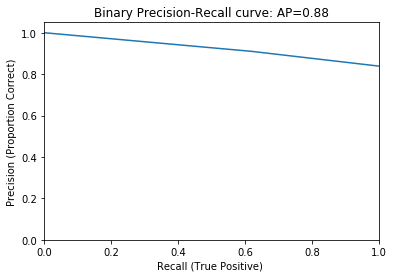

In [24]:
#Final model with entire dataset
xgb_final = xgb4

#Fit final model with entire dataset
x = df_feature_final
y = df_cleaned[response_var] #labels


# ==================== Print Results ====================
model = xgb_final

test_score = roc_auc_score(y_test, model.predict(x_test))
print('Test ROC-AUC score is: %.3f' % train_score)
precision, recall, _ = precision_recall_curve(y_test, model.predict(x_test))
print('Test Area Under P-R Curve: %.3f\n' % auc(recall, precision))
cm = confusion_matrix(y_test, model.predict(x_test))
print('Confusion Matrix:\n', cm)
print('\n{0} of {1} [{2}%]loans ROI<-20% were incorrectly labeled as ROI>-20%\n\n'.format(cm[0,1], 
                                                                                    cm[0,0]+cm[0,1], 
                                                                                    round(100*cm[0,1]/(cm[0,0]+cm[0,1]),2)))

# ==================== P-R Curve Plot ====================
average_precision = average_precision_score(y_test, model.predict(x_test))
plt.plot(recall, precision)
plt.xlabel('Recall (True Positive) ')
plt.ylabel('Precision (Proportion Correct)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [25]:
#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_train, xgb4.predict(x_train)).ravel()

#Calculate metrics

#Error Rate = ratio of all incorrect predictions
err_rate = (fp + fn) / (tp + tn + fn + fp) #lower better
print("Error rate  : ", round(err_rate*100,2))

#Accuracy = ratio of all correct predictions
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  : ", round(acc_*100,2))

#Sensitivity = True positive rate
sens_ = tp / (tp + fn) #sensitivity (higher better)
print("Sensitivity  : ", round(sens_*100, 2))

#Specificity = True negative rate
sp_ = tn / (tn + fp)
print("Specificity  : ", round(sp_*100, 2))

#Precision = ratio of incorrect positive predictions
FPR = fp / (tn + fp) 
print("False positive rate  : ", round(FPR*100,2))


Error rate  :  36.05
Accuracy  :  63.95
Sensitivity  :  63.02
Specificity  :  68.73
False positive rate  :  31.27
